<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio Clustering


### Contexto del Problema

Eres un científico de datos contratado por una federación deportiva internacional que desea mejorar sus programas de entrenamiento personalizados. La federación maneja una gran variedad de atletas que participan en diferentes disciplinas deportivas, y cada uno tiene necesidades de entrenamiento y desarrollo únicas. Para maximizar el rendimiento y mejorar la efectividad de los programas de entrenamiento, la federación quiere segmentar a sus atletas en grupos homogéneos basados en sus características físicas, habilidades y comportamientos de entrenamiento.


### Los datos

- **name**: Nombre del atleta. Es una variable categórica que identifica a cada atleta de manera única.

- **gender**: Género del atleta. Es una variable categórica que indica si el atleta es masculino ("Male") o femenino ("Female").

- **age**: Edad del atleta. Es una variable numérica que representa la edad del atleta en años.

- **height**: Altura del atleta. Es una variable numérica que representa la altura del atleta en centímetros.

- **nationality**: Nacionalidad del atleta. Es una variable categórica que indica el país de origen del atleta.

- **weight**: Peso del atleta. Es una variable numérica que representa el peso del atleta en kilogramos.

- **sports**: Deportes que practica el atleta. Es una variable categórica que puede contener múltiples valores (deportes) separados por comas.

- **hours_per_day**: Horas de entrenamiento por día. Es una variable numérica que indica el número promedio de horas que el atleta entrena cada día.

- **strength**: Fuerza del atleta. Es una variable numérica que representa la evaluación de la fuerza del atleta en una escala (por ejemplo, de 1 a 10).

- **agility**: Agilidad del atleta. Es una variable numérica que representa la evaluación de la agilidad del atleta en una escala (por ejemplo, de 1 a 10).

- **mental**: Capacidad mental del atleta. Es una variable numérica que representa la evaluación de la capacidad mental del atleta en una escala (por ejemplo, de 1 a 10).

- **federation**: Federación a la que pertenece el atleta. Es una variable categórica que indica la organización deportiva a la que está afiliado el atleta.

- **year_start**: Año de inicio. Es una variable numérica que indica el año en que el atleta comenzó su carrera o se unió a la federación.

- **rank**: Rango del atleta. Es una variable numérica que representa la posición o clasificación del atleta en su disciplina o federación.


### Objetivo del Ejercicio

El objetivo principal de este ejercicio es que los alumnos practiquen y desarrollen habilidades en el análisis de datos, preprocesamiento y técnicas de clustering aplicadas a un problema real en el ámbito deportivo. Al completar este ejercicio, los alumnos deberán ser capaces de:

1. **Realizar un Análisis Exploratorio de Datos (EDA)**:
    - Comprender la estructura y distribución de los datos.
    - Identificar patrones y relaciones significativas entre las variables.
    - Manejar valores faltantes y atípicos de manera efectiva.
    - Visualizar las características más relevantes.

2. **Preprocesar los Datos de Manera Adecuada**:
    - Convertir variables categóricas en variables numéricas.
    - Escalar las variables numéricas para asegurar una contribución equitativa al análisis de clustering.
    - Seleccionar las características más relevantes que contribuirán al análisis de clustering.

3. **Aplicar Técnicas de Clustering para Segmentar a los Atletas**:
    - Probar diferentes métodos de clustering (e.g., K-means, DBSCAN, Hierarchical Clustering) para identificar el más adecuado para los datos proporcionados.
    - Determinar el número óptimo de clusters utilizando métodos como el codo (Elbow Method) o la silueta (Silhouette Score).
    - Visualizar los clusters obtenidos y analizar sus características distintivas.

4. **Extraer Conclusiones y Proporcionar Recomendaciones de Entrenamiento**:
    - Describir las características principales de cada cluster identificado.
    - Proporcionar recomendaciones prácticas y accionables para personalizar los programas de entrenamiento para cada grupo de atletas.
¡

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import math
import numpy as np

from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

from src.support_prep import scale_data
from src.support_clustering import *

import warnings
warnings.filterwarnings("ignore")

## EDA

In [2]:
df = pd.read_csv("datos/WrestlingWorldTournament.csv", index_col=0)

In [3]:
df.head()

,name,gender,age,height,nationality,weight,sports,hours_per_day,strength,agility,mental,federation,year_start,rank
0,Aaron Peavy,Female,41,165.0,England,82,"Boxing, MMA",3,7,8,7,Fight Zone Wrestling,1989,42
1,Abe Rutland,Male,36,185.0,Japan,100,Judo,0,8,5,9,World Wrestling Entertainment,2006,161
2,Adrian Quinn,Male,29,178.5,Japan,93,Karate,4,8,8,7,World Wrestling Entertainment,2012,153
3,Alan Beckham,Male,39,187.5,Japan,107,Judo,3,7,6,8,Fight Zone Wrestling,2003,252
4,Albertha Rodriguez,Female,29,158.0,USA,72,MMA,1,5,7,7,Consejo Global de Lucha Libre,2012,360


Lo primero que haremos será comprobar si hay nulos y duplicados.

In [4]:
print("Nulos:", df.isna().any().sum())
print("Duplicados:", df.duplicated().sum())

Nulos: 0
Duplicados: 0


Ahora que no tenemos, vamos a fijarnos en una de las categorías más curiosas: **sports**. Esta contiene múltiples valores para varios atletas, lo cual nos puede generar muchas categorías únicas en caso de tratarlas como diferentes entre sí. Para tratar con esto, vamos a hacer un explode de esta categoría, lo cual nos permitirá tener de forma más fiel a la realidad el conteo de personas en cada uno de los deportes que se practican en nuestro conjunto de datos.

In [5]:
df["sports"] = df["sports"].str.split(",")

Además vamos a crear también una nueva categoría que nos mantenga la info de la cantidad de deportes practicados por atleta.

In [6]:
df["number_of_sports"] = df["sports"].apply(len)

In [7]:
df_exploded = df.explode("sports")

In [8]:
df_exploded["sports"] = df_exploded["sports"].str.strip()

In [9]:
df_exploded.reset_index(drop=True, inplace=True)

Creamos una variable que albergue los conteos de la cantidad de atletas en cada uno de los deportes.

In [10]:
sport_counts = df_exploded.groupby("sports")["name"].count().reset_index()

In [11]:
df_exploded.head()

,name,gender,age,height,nationality,weight,sports,hours_per_day,strength,agility,mental,federation,year_start,rank,number_of_sports
0,Aaron Peavy,Female,41,165.0,England,82,Boxing,3,7,8,7,Fight Zone Wrestling,1989,42,2
1,Aaron Peavy,Female,41,165.0,England,82,MMA,3,7,8,7,Fight Zone Wrestling,1989,42,2
2,Abe Rutland,Male,36,185.0,Japan,100,Judo,0,8,5,9,World Wrestling Entertainment,2006,161,1
3,Adrian Quinn,Male,29,178.5,Japan,93,Karate,4,8,8,7,World Wrestling Entertainment,2012,153,1
4,Alan Beckham,Male,39,187.5,Japan,107,Judo,3,7,6,8,Fight Zone Wrestling,2003,252,1


Vemos que realmente tenemos 342 atletas que practican más de un deporte. Esto, considerando que hay 500 atletas en total, podría ser relevante a la hora de crear clústeres con nuestros datos.

In [12]:
(df["number_of_sports"]>1).sum()

342

Vamos a visualizar nuestras variables y cómo se distribuyen:

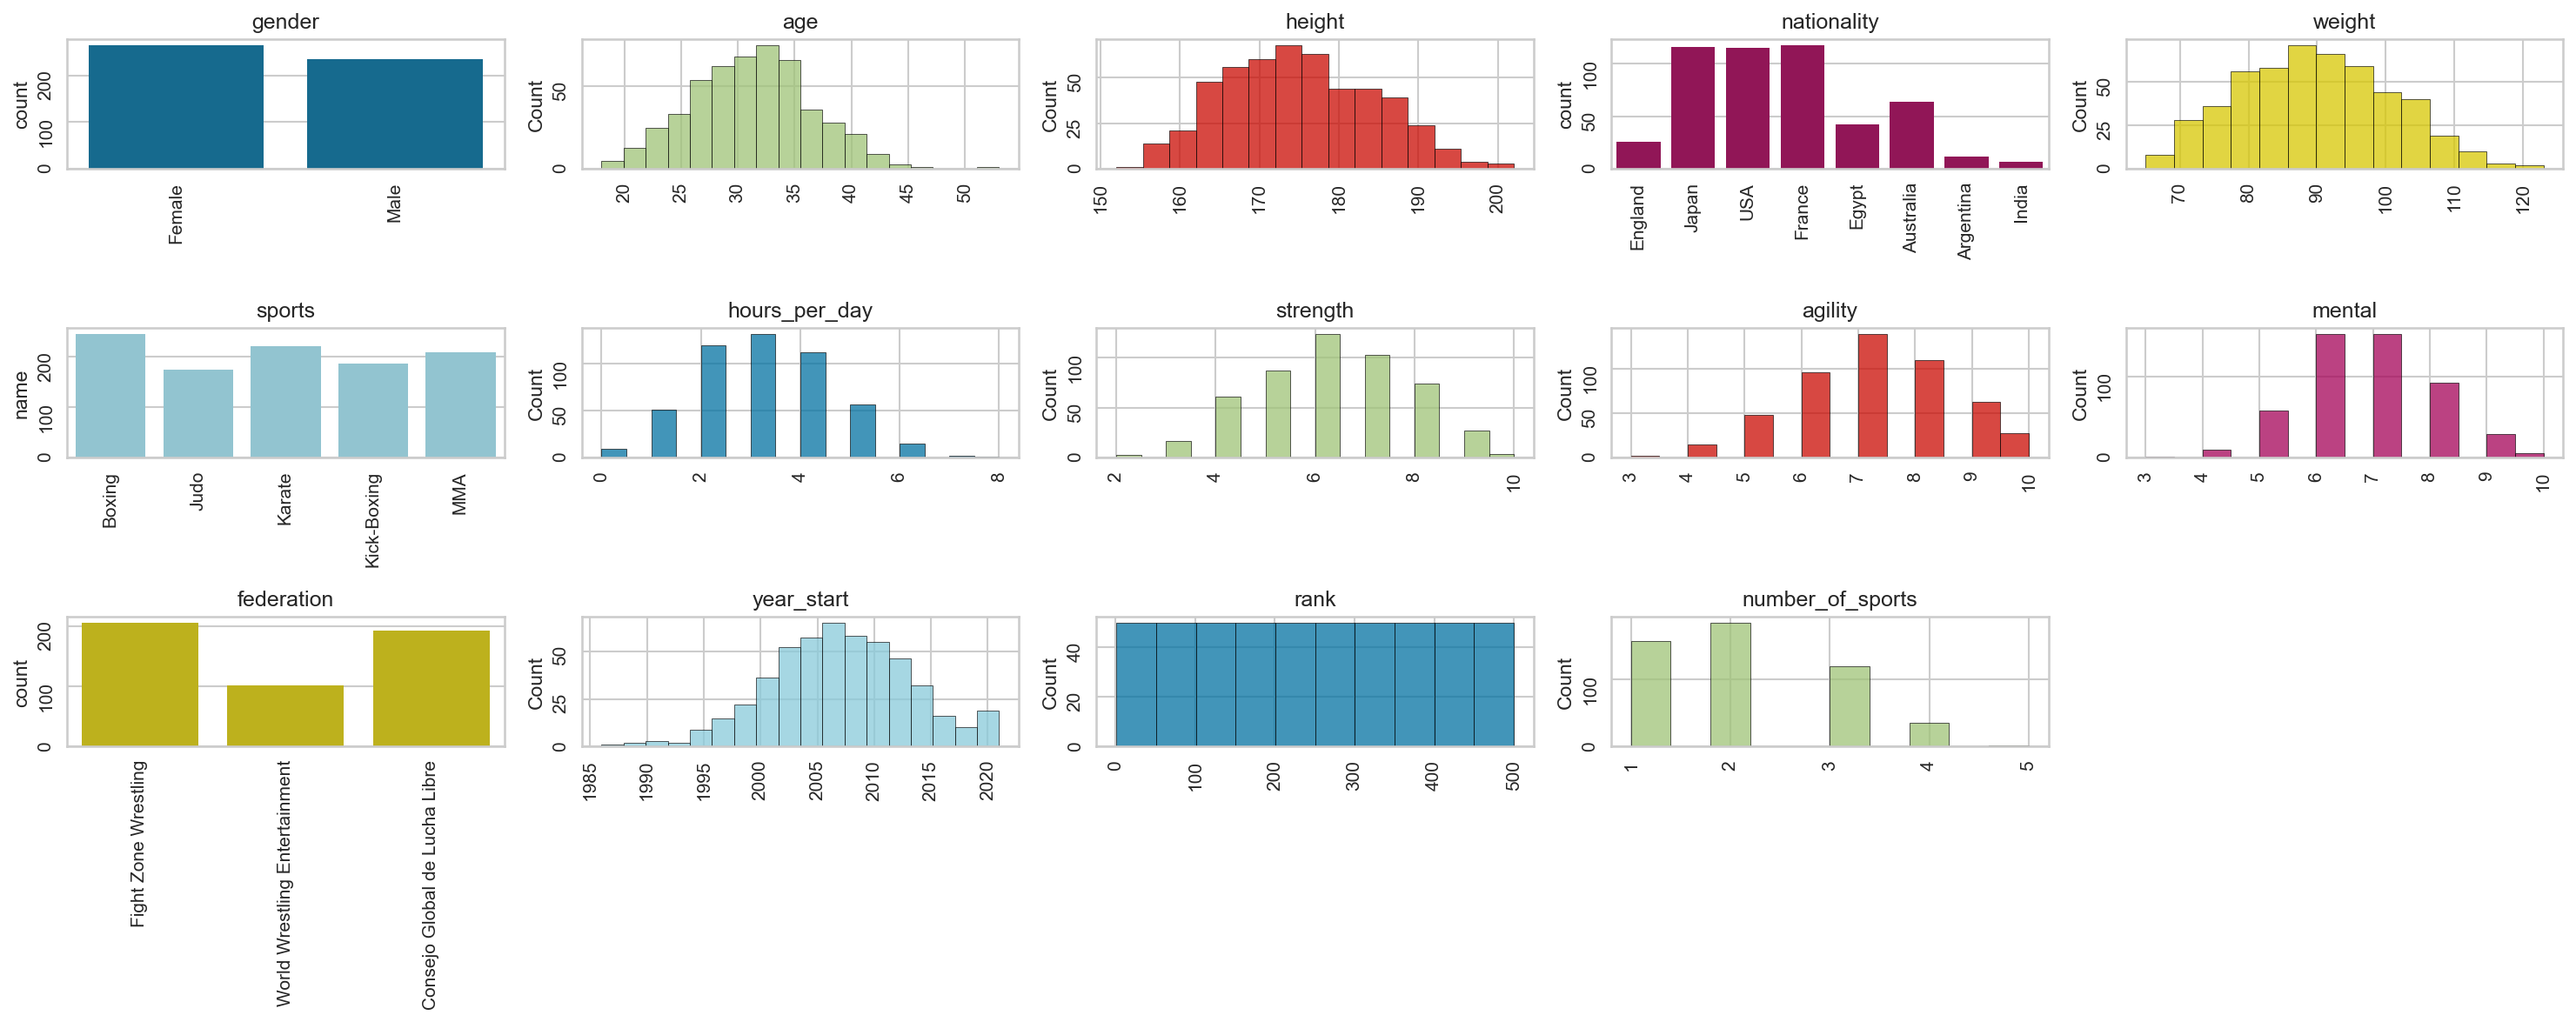

In [13]:
df_noname = df.drop(columns="name")
num_cols = df_noname.select_dtypes("number").columns
cat_cols = df_noname.select_dtypes("O").columns

fig, axes = plt.subplots(nrows = 3, ncols = math.ceil(len(df_noname.columns)/3), figsize = (20,8), dpi = 150)
axes = axes.flat
colors = plt.rcParams["axes.prop_cycle"]()

for i, col in enumerate(df_noname.columns):
    if col == "sports":
        sns.barplot(data = sport_counts, x = "sports", y ="name", ax = axes[i], color = next(colors)["color"])
    elif col in num_cols:
        sns.histplot(data = df, x = col, ax = axes[i], color = next(colors)["color"])
    elif col in cat_cols:
        sns.countplot(data = df, x = col, ax = axes[i], color = next(colors)["color"])
    elif col == "number_of_sports":
        sns.histplot(data = df, x = col, ax = axes[i])
    axes[i].tick_params(rotation = 90)
    axes[i].set_xlabel("")
    axes[i].set_title(col)
plt.tight_layout()
if len(df_noname.columns)%3 != 0:
    fig.delaxes(axes[-1])
plt.show()

Vemos que hay un reparto bastante equitativo de los géneros, las numéricas tienen distribuciones bastante normales. Además rank tiene un aspecto muy uniforme, lo cual podría significar que solo hay valores únicos. Trataremos con ellos más adelante. En cuanto a los deportes también vemos una distribución bastante uniforme, lo que indica que no hay ninguno que sea predominante. Esto nos dice que es viable no considerarla para nuestro clustering, al igual que la federación.

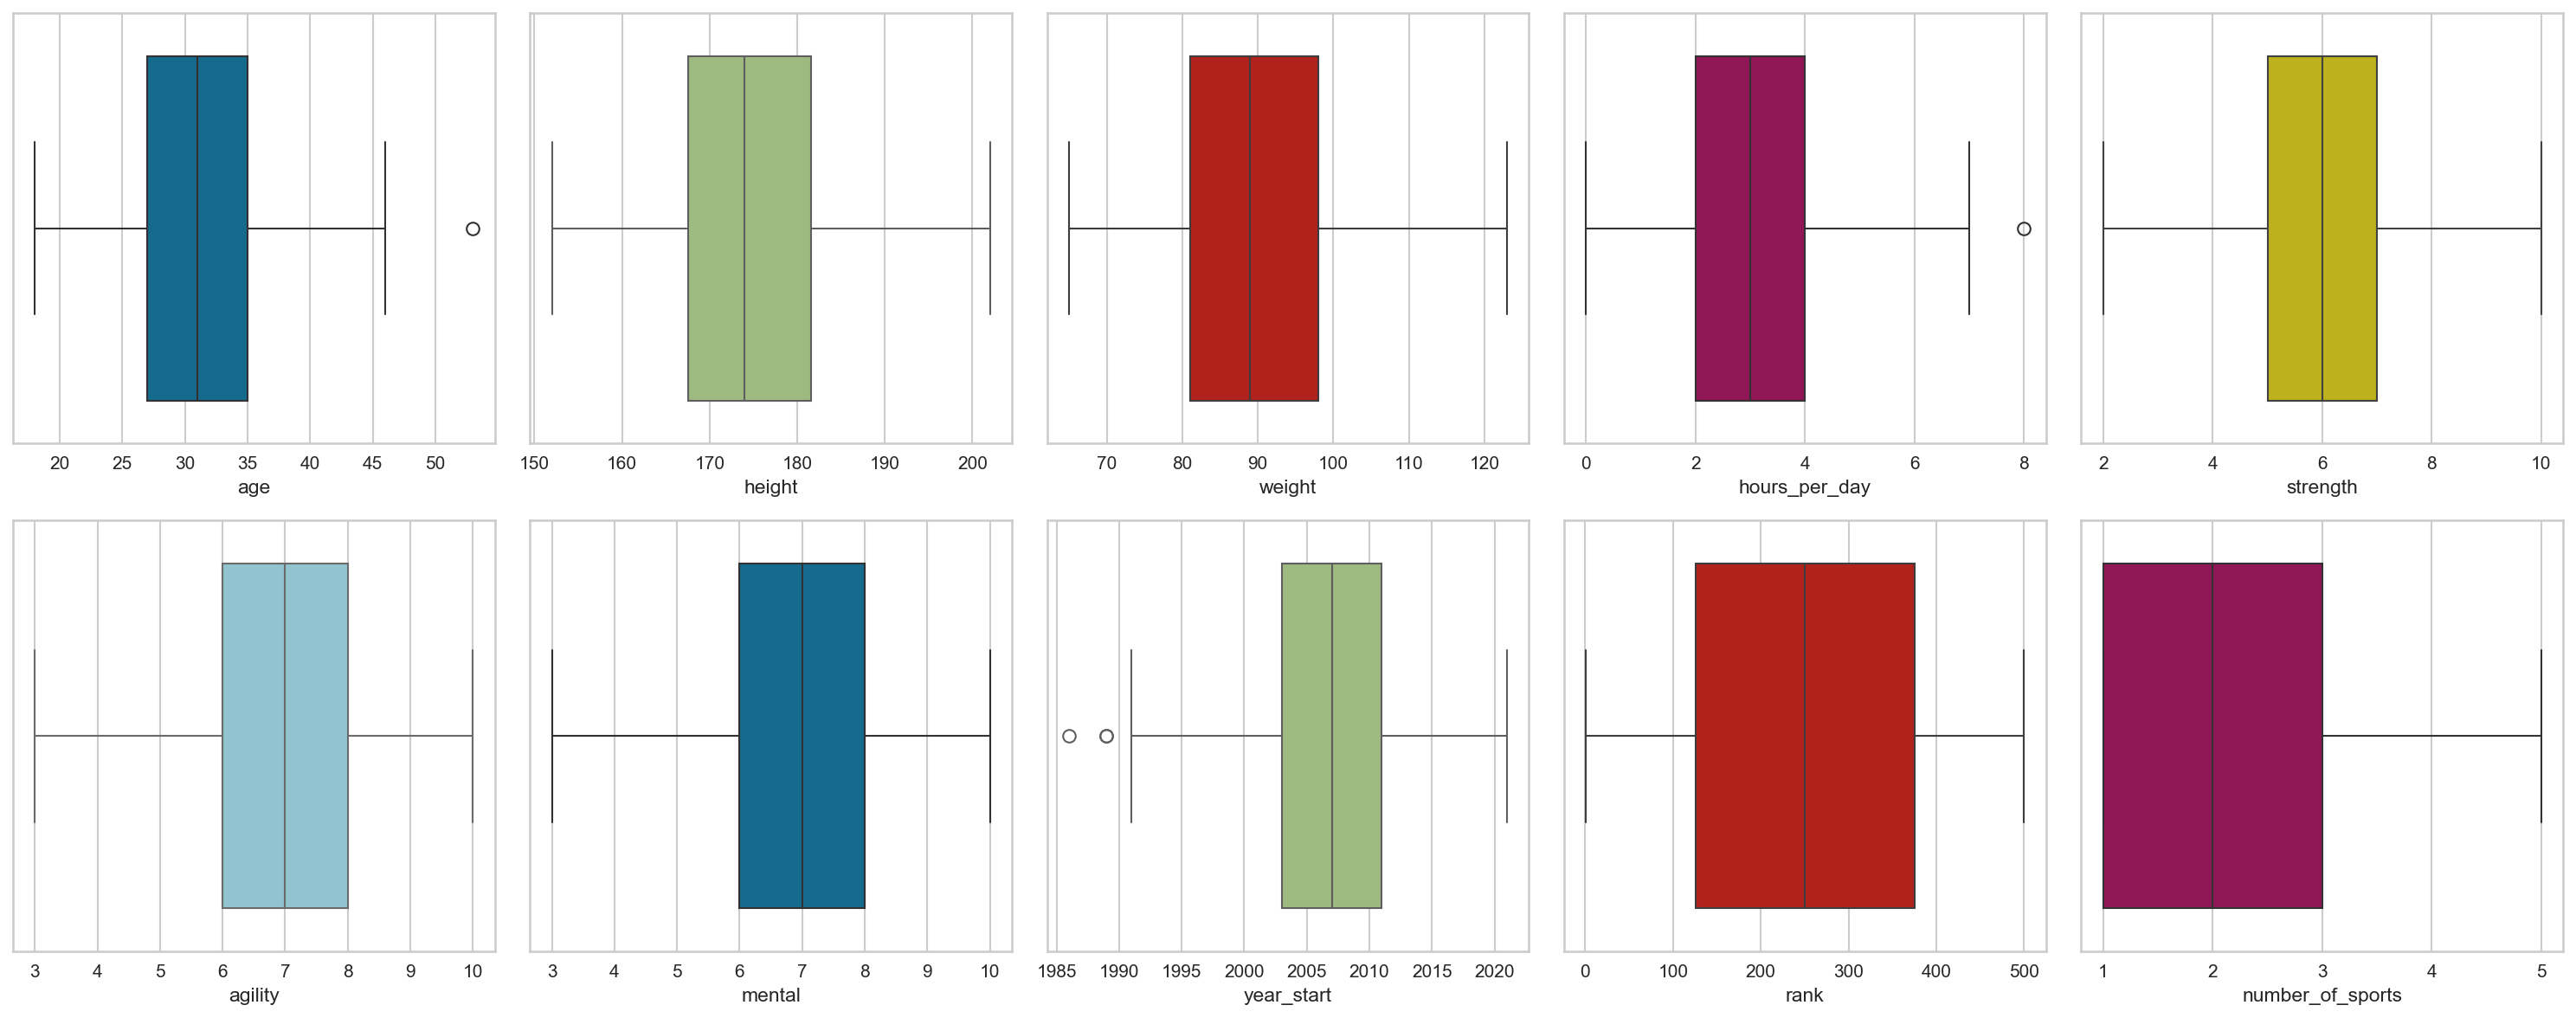

In [14]:
fig, axes = plt.subplots(nrows = 2, ncols = math.ceil(len(num_cols)/2), figsize = (20,8), dpi = 150)
axes = axes.flat
colors = plt.rcParams["axes.prop_cycle"]()

for i, col in enumerate(num_cols):
    sns.boxplot(data = df, x = col, ax = axes[i], color = next(colors)["color"])
plt.tight_layout()
plt.show()

En cuanto a las distribuciones de las numéricas y sus outliers, vemos un poco lo que ya vimos en los histogramas: distribuciones bastante normales y muy pocos outliers. Esto nos ayudará a elegir un método de estandarización más adelante.

Para las correlaciones:

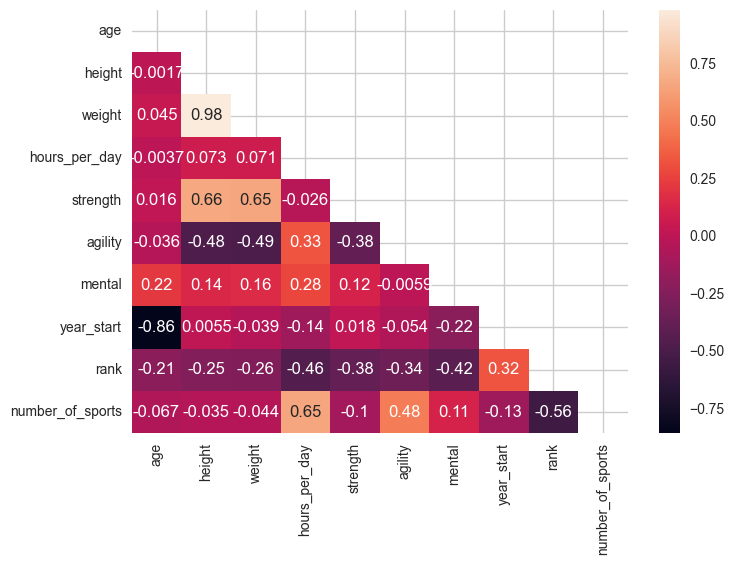

In [15]:
plt.figure()
mask = np.triu(np.ones_like(df[num_cols].corr(numeric_only=True), dtype=np.bool_))
sns.heatmap(df[num_cols].corr(), annot = True, mask = mask)
plt.show()

Vemos que hay correlaciones muy razonables, como la altura y el peso de un atleta, directamente correlacionados. Otra que es razonable es el número de deportes con las horas por día, ya que un atleta que practica más de un deporte practica más tiempo al día. También el rango y número de deportes, tiene sentido. Al practicar más deportes, un atleta se centra menos en un deporte en específico, habiendo menor posibilidad de tener una buena posición en el ranking.

### Encoding

Para el encoding vamos a usar un frequency encoder, ya que querremos usar los valores de la frecuencia para que el agrupamiento esté claro, se juntarán registros con valores similares, ya sean bajos o altos en frecuencia.

In [16]:
df_exploded_enc = df_exploded.copy()
for col in cat_cols:
    
    frecuencia = df_exploded[col].value_counts(normalize=True)
    df_exploded_enc[col] = df_exploded_enc[col].map(frecuencia)

In [17]:
df_exploded_enc.head()

,name,gender,age,height,nationality,weight,sports,hours_per_day,strength,agility,mental,federation,year_start,rank,number_of_sports
0,Aaron Peavy,0.531792,41,165.0,0.052023,82,0.236994,3,7,8,7,0.425819,1989,42,2
1,Aaron Peavy,0.531792,41,165.0,0.052023,82,0.202312,3,7,8,7,0.425819,1989,42,2
2,Abe Rutland,0.468208,36,185.0,0.229287,100,0.168593,0,8,5,9,0.193642,2006,161,1
3,Adrian Quinn,0.468208,29,178.5,0.229287,93,0.212909,4,8,8,7,0.193642,2012,153,1
4,Alan Beckham,0.468208,39,187.5,0.229287,107,0.168593,3,7,6,8,0.425819,2003,252,1


### Feature Scaling

Para el escalado, usaremos `minmax`, ya que el frequency ya nos aporta valores entre 0 y 1, además de que nos interesa mantener una escala similar. Otra razón es la casi normalidad de los datos en muchas de las variables y la presencia escasa de atípicos univariados.

In [18]:
df_scaled, scaler = scale_data(data = df_exploded_enc, columns = df_exploded_enc.columns.drop("name"), method = "minmax")

In [19]:
df_scaled.head()

,gender,age,height,nationality,weight,sports,hours_per_day,strength,agility,mental,federation,year_start,rank,number_of_sports
0,1.0,0.657143,0.26,0.162698,0.293103,1.000000,0.375,0.625,0.714286,0.571429,1.0,0.085714,0.082164,0.25
1,1.0,0.657143,0.26,0.162698,0.293103,0.492958,0.375,0.625,0.714286,0.571429,1.0,0.085714,0.082164,0.25
2,0.0,0.514286,0.66,0.892857,0.603448,0.000000,0.000,0.750,0.285714,0.857143,0.0,0.571429,0.320641,0.00
3,0.0,0.314286,0.53,0.892857,0.482759,0.647887,0.500,0.750,0.714286,0.571429,0.0,0.742857,0.304609,0.00
4,0.0,0.600000,0.71,0.892857,0.724138,0.000000,0.375,0.625,0.428571,0.714286,1.0,0.485714,0.503006,0.00


## Clustering

Para la clusterización elegiremos deshacernos de algunas de las variables disponibles. El rango se ha apreciado que no es como se define, hay 500 valores únicos que no se repiten, lo cual es lo esperado si es el ranking por federación. Entonces, este valor no nos aporta información y no es representativo para el agrupamiento de los atletas. Asociado a esto entonces está la federación, la cual también omitiremos para el clustering. 

La nacionalidad también vamos a elegir omitirla, ya que el objetivo de este proceso es agrupar por cualidades físicas, y la nacionalidad no debería tener relación directa (la raza sería otra cuestión).

In [20]:
df_scaled.drop(columns=["rank", "federation", "nationality"], inplace=True)

num_cols = num_cols.drop(["rank"])
cat_cols = cat_cols.drop(["federation", "nationality"])

In [21]:
best_models = search_best_model(data = df_scaled, random_state=42, sort_metric="davies_bouldin_score")
best_models.head()

,model,distance,silhouette_score,davies_bouldin_score,n_clusters,cardinality
0,Kmeans,euclidean,0.403804,1.075011,2,"{0: 552, 1: 486}"
1,Kmedoids,cosine,0.403804,1.075011,2,"{1: 552, 0: 486}"
2,Kmedoids,chebyshev,0.403804,1.075011,2,"{1: 552, 0: 486}"
3,Kmedoids,manhattan,0.396520,1.090097,2,"{1: 558, 0: 480}"
4,Kmeans,euclidean,0.313771,1.417160,3,"{0: 552, 1: 196, 2: 290}"


Vamos a probar n_clusters = 2

In [22]:
model = KMeans(n_clusters=2, random_state=42)
model.fit(df_scaled)
labels = model.labels_
df_scaled["cluster"] = labels

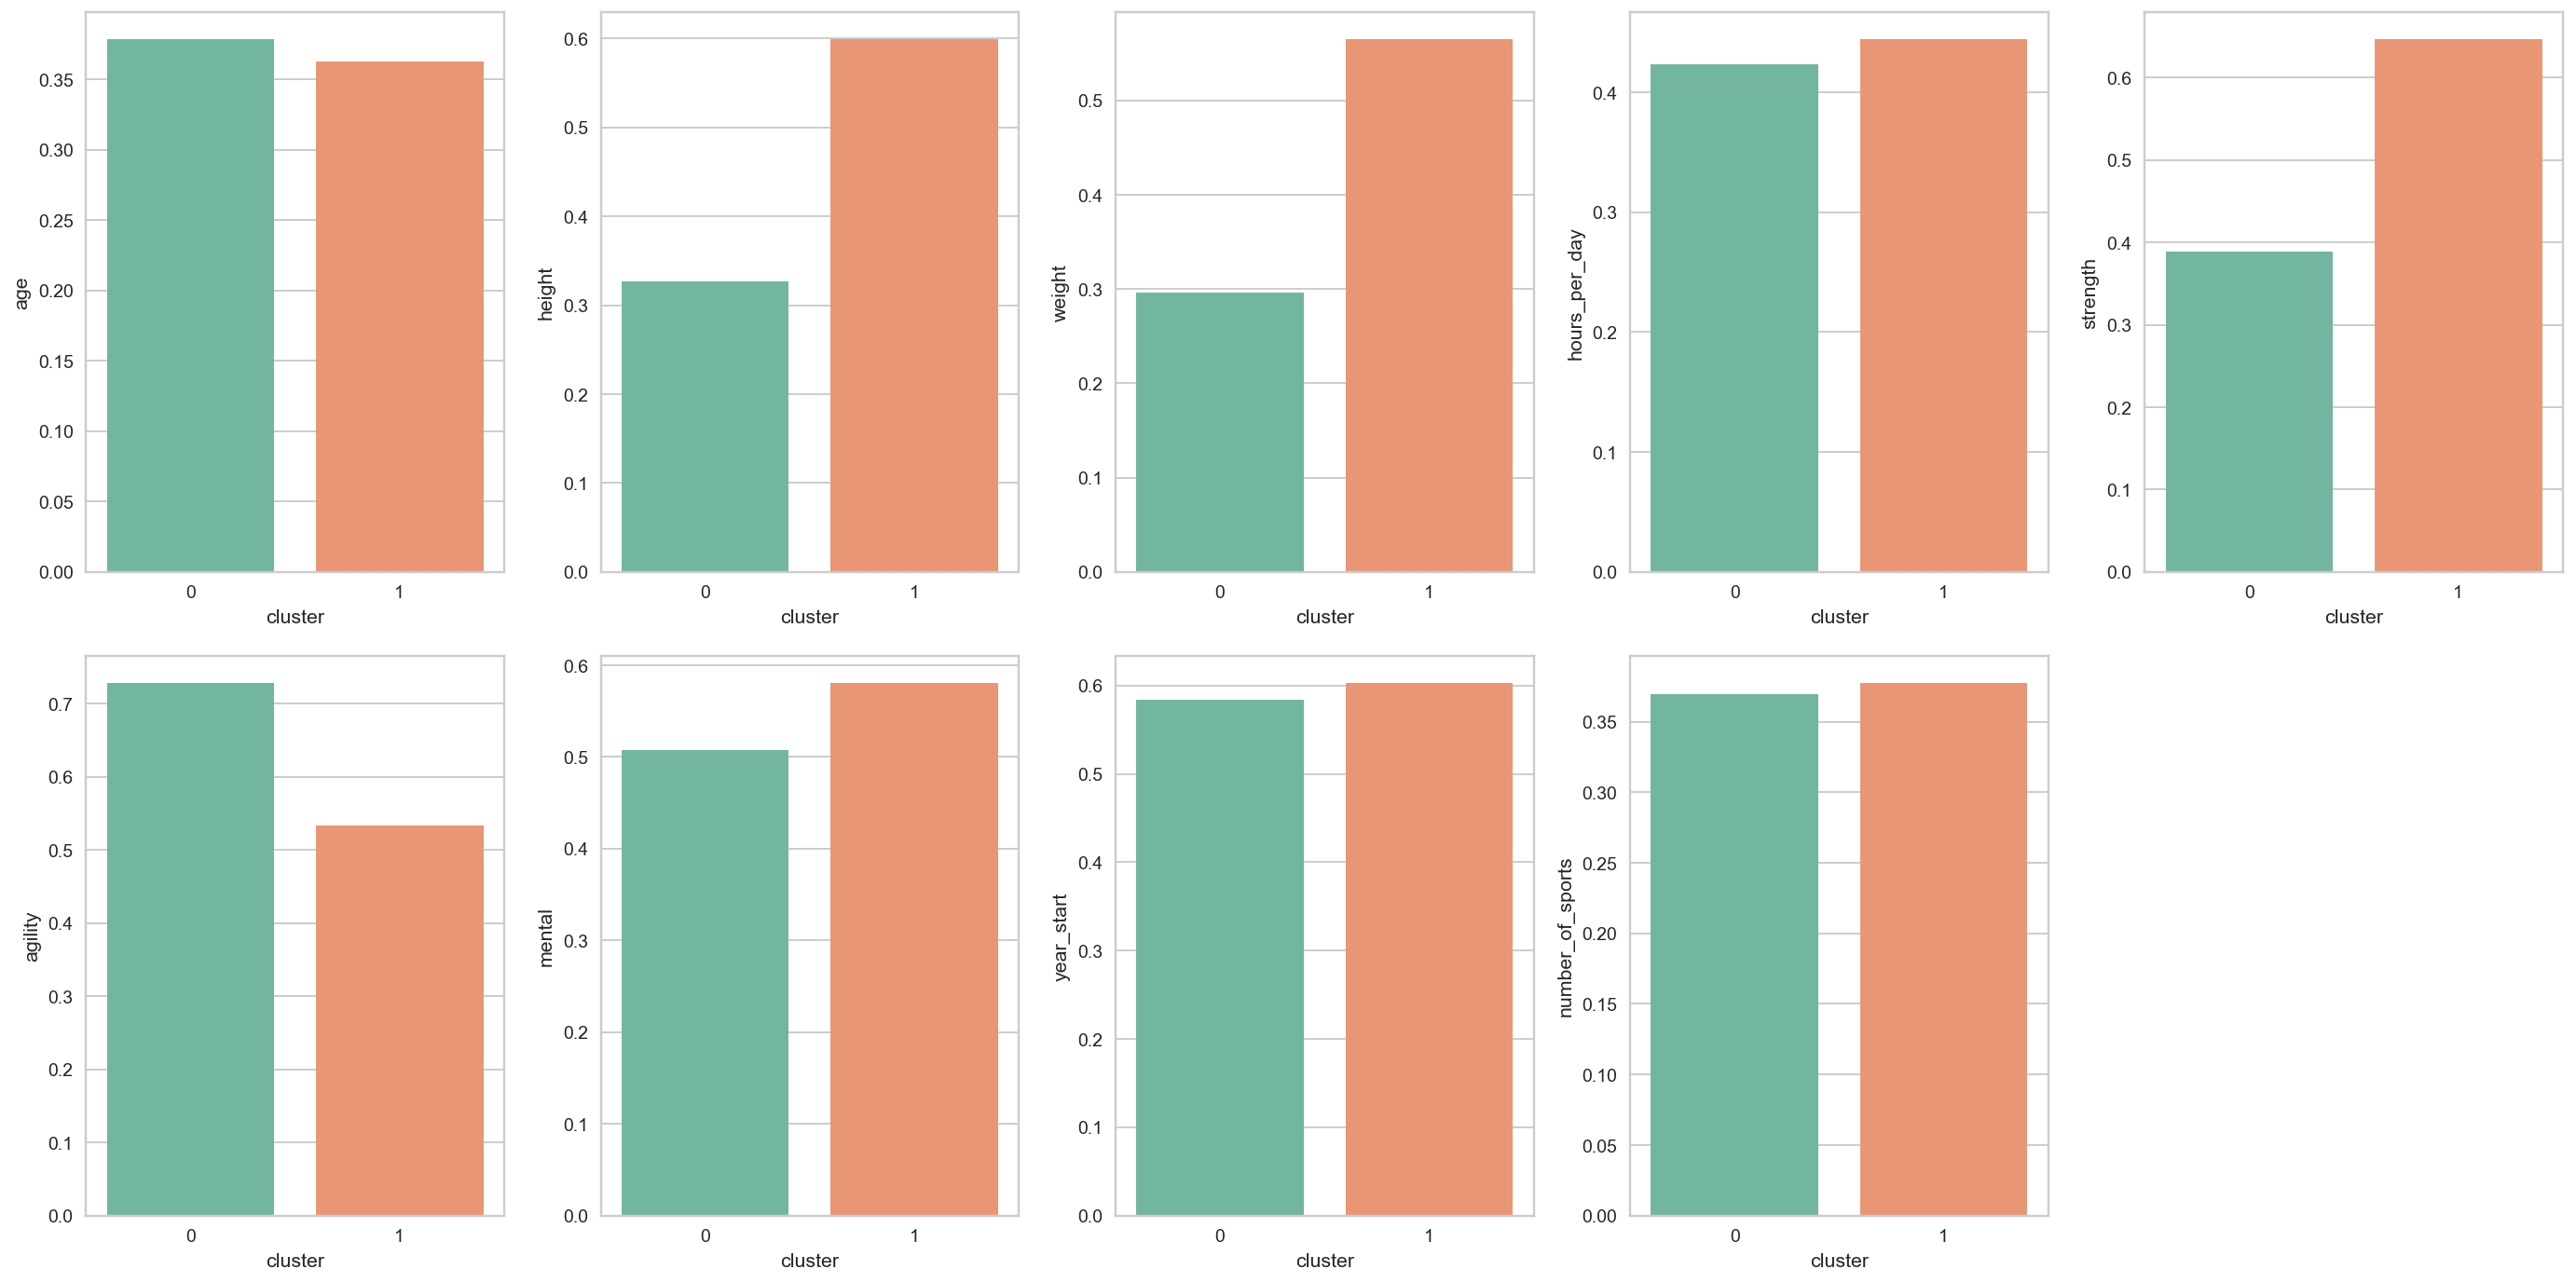

In [23]:
fig, axes = plt.subplots(nrows = 2, ncols = math.ceil(len(num_cols)/2), figsize = (20,10), dpi = 140)
axes = axes.flat

for i, col in enumerate(num_cols):
    df_grouped = df_scaled.groupby("cluster")[col].mean().reset_index()
    sns.barplot(data = df_grouped, x = "cluster", y = col, ax = axes[i], palette = "Set2")
plt.tight_layout()
plt.delaxes(axes[-1])
plt.show()

Las diferencias entre los clústers son bastante razonables: un grupo contiene valores más altos en fuerza, peso, mientras que el otro grupo tiene mayor agilidad debido a menores pesos. No vemos mucha diferencia en la edad (y por tanto el year_start), ni el número de deportes practicados (y por tanto las horas por día). Es puramente un clustering a nivel físico.

In [24]:
df_scaled.groupby(["gender", "cluster"])["age"].count().reset_index()

,gender,cluster,age
0,0.0,1,486
1,1.0,0,552


Vemos que el género es un caso diferencial: los clústers se dividen por géneros. Podría parecer una sorpresa, pero a nivel atlético los hombres y las mujeres presentan diferencias significativas que podrían justificar el por qué de este agrupamiento.

Otra visualización que podría ser útil sería un scatterplot, donde plotearemos algunas de las características más relevantes en la elección de clusters, y de esta forma podremos ver qué tan bien se realiza la separación de grupos.

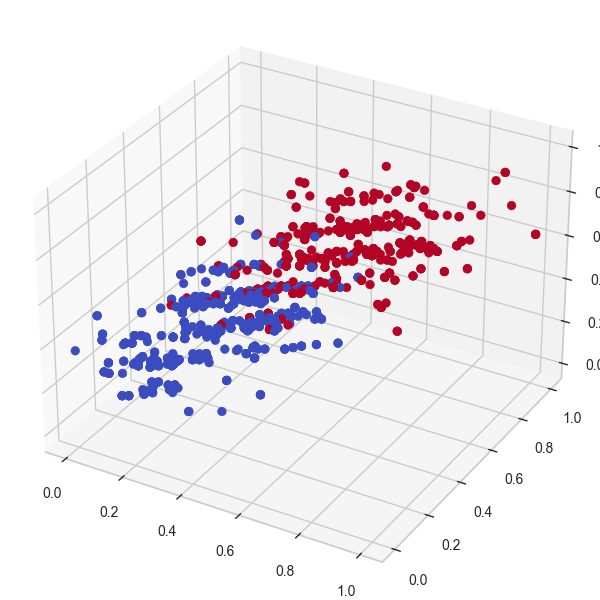

In [25]:
%matplotlib widget

fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
cmap = plt.get_cmap("coolwarm")
x = df_scaled["cluster"]
sc = ax.scatter(df_scaled["weight"], df_scaled["height"], df_scaled["strength"], s=40, c=x, marker='o', cmap=cmap, alpha=1)
plt.show() 


Vemos que, aunque de primeras pueda parecer que hay un solapamiento, este podría no serlo al añadir más dimensiones (más variables). Se observa una buena separación entre los dos clústers.